#Downloading Eye Diseases Dataset

In [6]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 97% 713M/736M [00:09<00:00, 132MB/s]
100% 736M/736M [00:09<00:00, 81.9MB/s]


In [7]:
!unzip /content/eye-diseases-classification.zip

Archive:  /content/eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/catara

#Importing the Necessary Libraries

In [8]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import cv2
from PIL import Image
from tqdm import tqdm

from skimage.io import imread
from skimage.transform import rescale
from skimage.feature import hog
from skimage import exposure
from skimage import color

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


In [9]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
from keras.models import Sequential, Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adam, Adamax
from keras.layers import Input, UpSampling2D, Conv2D, concatenate, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.regularizers import l1, l2



In [10]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input


In [11]:
import os
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Creating a Combined Image Dataset with Labels

In [12]:
%mkdir dataset

mkdir: cannot create directory ‘dataset’: File exists


In [13]:
data_dir = "/content/dataset"

cataract_df = pd.DataFrame(columns=['filepaths', 'labels'])
diabetic_retinopathy_df = pd.DataFrame(columns=['filepaths', 'labels'])
glaucoma_df = pd.DataFrame(columns=['filepaths', 'labels'])
normal_df = pd.DataFrame(columns=['filepaths', 'labels'])

cataract_label = 'cataract'
diabetic_retinopathy_label = 'diabetic_retinopathy'
glaucoma_label = 'glaucoma'
normal_label = 'normal'


cataract_files = os.listdir(os.path.join(data_dir, "cataract"))
diabetic_retinopathy_files = os.listdir(os.path.join(data_dir, "diabetic_retinopathy"))
glaucoma_files = os.listdir(os.path.join(data_dir, "glaucoma"))
normal_files = os.listdir(os.path.join(data_dir, "normal"))


cataract_df['filepaths'] = [os.path.join(data_dir, "cataract", filename) for filename in cataract_files]
cataract_df['labels'] = cataract_label

diabetic_retinopathy_df['filepaths'] = [os.path.join(data_dir, "diabetic_retinopathy", filename) for filename in diabetic_retinopathy_files]
diabetic_retinopathy_df['labels'] = diabetic_retinopathy_label

glaucoma_df['filepaths'] = [os.path.join(data_dir, "glaucoma", filename) for filename in glaucoma_files]
glaucoma_df['labels'] = glaucoma_label

normal_df['filepaths'] = [os.path.join(data_dir, "normal", filename) for filename in normal_files]
normal_df['labels'] = normal_label


In [14]:
combined_df = pd.concat([cataract_df, diabetic_retinopathy_df], ignore_index=True)
combined_df = pd.concat([combined_df, glaucoma_df], ignore_index=True)
combined_df = pd.concat([combined_df, normal_df], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42)
label_counts = combined_df['labels'].value_counts()

label_counts

labels
diabetic_retinopathy    1098
normal                  1074
cataract                1038
glaucoma                1007
Name: count, dtype: int64

In [15]:
combined_df.head(5)

filepaths                labels
463          /content/dataset/cataract/_120_2375814.jpg              cataract
2426         /content/dataset/glaucoma/_321_9678485.jpg              glaucoma
2661         /content/dataset/glaucoma/_391_1332495.jpg              glaucoma
1483  /content/dataset/diabetic_retinopathy/10903_ri...  diabetic_retinopathy
2860         /content/dataset/glaucoma/Glaucoma_060.png              glaucoma

#Exploring Data Distribution and Visualizing Images

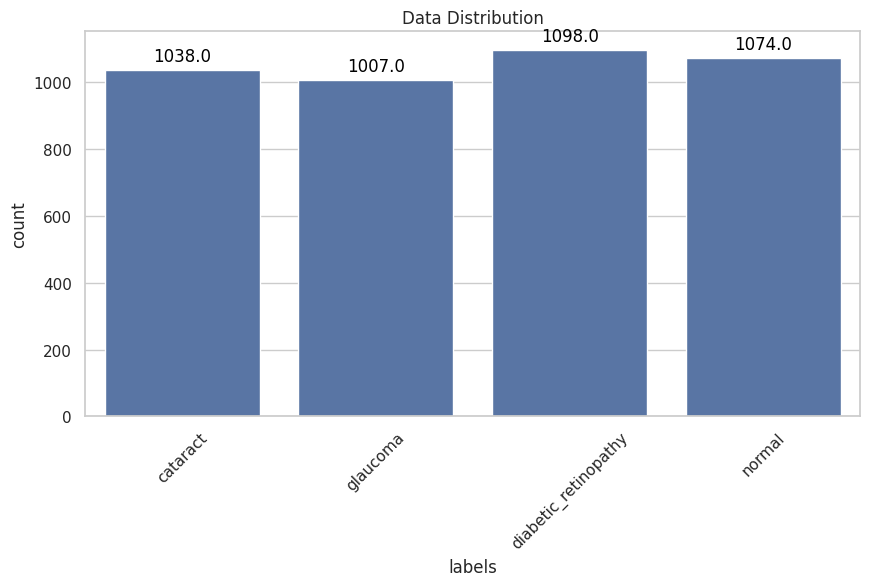

In [16]:
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid")
ax = sns.countplot(data=combined_df, x='labels')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=12, color='black', xytext=(0, 10), textcoords='offset points')

plt.title('Data Distribution')
plt.xticks(rotation=45)
plt.show()


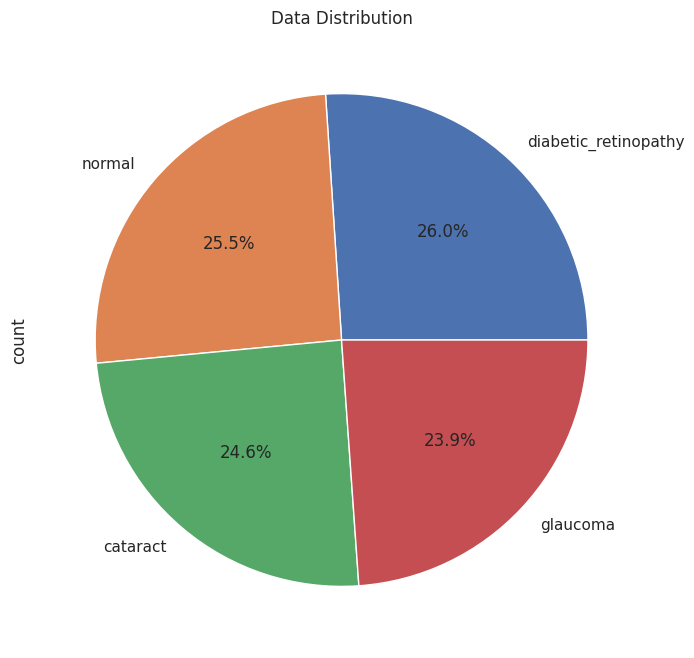

In [17]:
plt.figure(figsize=(10, 8))
combined_df['labels'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Data Distribution')
plt.show()

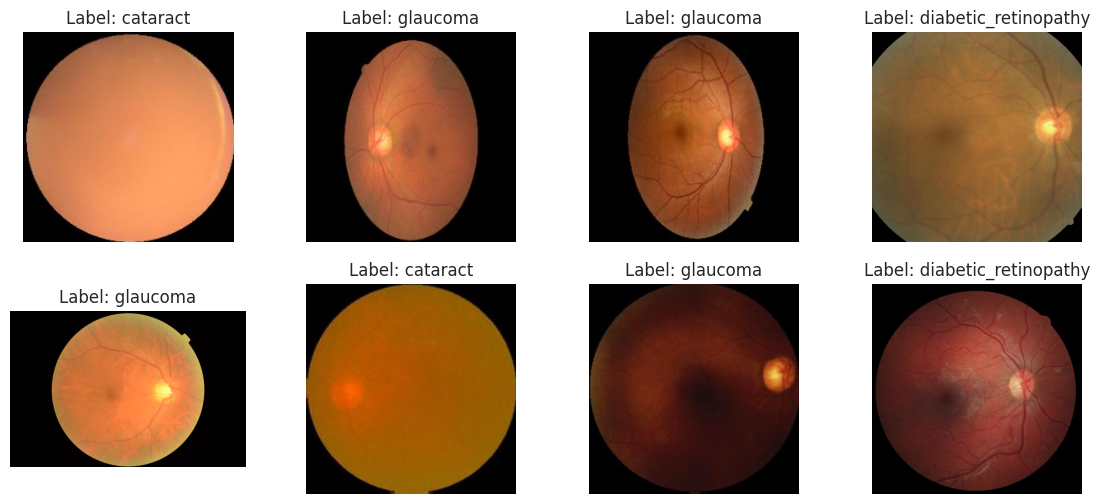

In [18]:
def display_images(df, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))
    for r in range(rows):
        for c in range(cols):
            index = r * cols + c
            if index < len(df):
                image_path = df.iloc[index]['filepaths']
                label = df.iloc[index]['labels']
                img = Image.open(image_path)
                axes[r, c].imshow(img)
                axes[r, c].set_title(f'Label: {label}')
                axes[r, c].axis('off')
            else:
                axes[r, c].axis('off')

    plt.show()

rows = 2
cols = 4

display_images(combined_df, rows, cols)

#Data Splitting and Class Distribution in Image Dataset

In [19]:
train_df, dummy_df = train_test_split(combined_df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= combined_df['labels'])

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= dummy_df['labels'])

In [20]:
train_df['labels'].value_counts()

labels
diabetic_retinopathy    878
normal                  859
cataract                830
glaucoma                806
Name: count, dtype: int64

In [21]:
test_df['labels'].value_counts()

labels
diabetic_retinopathy    110
normal                  107
cataract                104
glaucoma                101
Name: count, dtype: int64

In [22]:
valid_df['labels'].value_counts()

labels
diabetic_retinopathy    110
normal                  108
cataract                104
glaucoma                100
Name: count, dtype: int64

#Data Preprocessing and Generation

In [23]:
def scalar(img):
        return img

train_generator = ImageDataGenerator(preprocessing_function = scalar,
                                     horizontal_flip = True)

test_generator = ImageDataGenerator(preprocessing_function = scalar)

In [24]:
train_set = train_generator.flow_from_dataframe( train_df,
                                        x_col= 'filepaths',
                                        y_col= 'labels',
                                        target_size= (224, 224),
                                        class_mode= 'categorical',
                                        color_mode= 'rgb',
                                        shuffle= True,
                                        batch_size= 40)

Found 3373 validated image filenames belonging to 4 classes.


In [25]:
train_set.class_indices

{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}

In [26]:
valid_set = test_generator.flow_from_dataframe( valid_df,
                                       x_col= 'filepaths',
                                       y_col= 'labels',
                                       target_size= (224, 224),
                                       class_mode= 'categorical',
                                       color_mode= 'rgb',
                                       shuffle= True,
                                       batch_size= 40)


Found 422 validated image filenames belonging to 4 classes.


In [27]:
test_set = test_generator.flow_from_dataframe( test_df,
                                      x_col= 'filepaths',
                                      y_col= 'labels',
                                      target_size= (224, 224),
                                      class_mode= 'categorical',
                                      color_mode= 'rgb',
                                      shuffle= False,
                                      batch_size= 2)

Found 422 validated image filenames belonging to 4 classes.


#Deep Learning Models

##Transfer Learning(TL)

###InceptionResNetV2-based Neural Network Architecture

In [28]:
base_model = InceptionResNetV2(include_top= False, weights= "imagenet", input_shape= (224,224,3), pooling= 'max')

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)

from tensorflow.keras.regularizers import l2, l1

x = Dense(256, kernel_regularizer=l2(0.016), activity_regularizer=l1(0.006), bias_regularizer=l1(0.006), activation='relu')(x)

x = Dropout(rate=0.3)(x)

output = Dense(4, activation='softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 54,737,380 (208.81 MB)

 Trainable params: 54,673,764 (208.56 MB)

 Non-trainable params: 63,616 (248.50 KB)

###Training the Model

In [29]:
history = model.fit(x= train_set,
                    epochs= 10,
                    verbose= 1,
                    validation_data= valid_set
)



Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.3125 - loss: 13.9202 - val_accuracy: 0.2796 - val_loss: 7.8395
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 71s 817ms/step - accuracy: 0.2580 - loss: 7.6639 - val_accuracy: 0.2678 - val_loss: 7.2706
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 77s 753ms/step - accuracy: 0.2654 - loss: 7.1586 - val_accuracy: 0.3033 - val_loss: 6.7865
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 62s 715ms/step - accuracy: 0.2450 - loss: 6.6540 - val_accuracy: 0.2488 - val_loss: 6.2806
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 83s 736ms/step - accuracy: 0.2587 - loss: 6.1553 - val_accuracy: 0.2583 - val_loss: 5.8041
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 65s 738ms/step - accuracy: 0.2726 - loss: 5.6808 - val_accuracy: 0.2464 - val_loss: 5.5176
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 81s 732ms/step - accuracy: 0.2505 - loss: 5.2271 - val_accuracy: 0.2085 - val_loss: 5.5587
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 64s 726ms/step - accuracy: 0.2537 - loss: 4.7944 - val_accur

###Training and Validation Performance Visualization

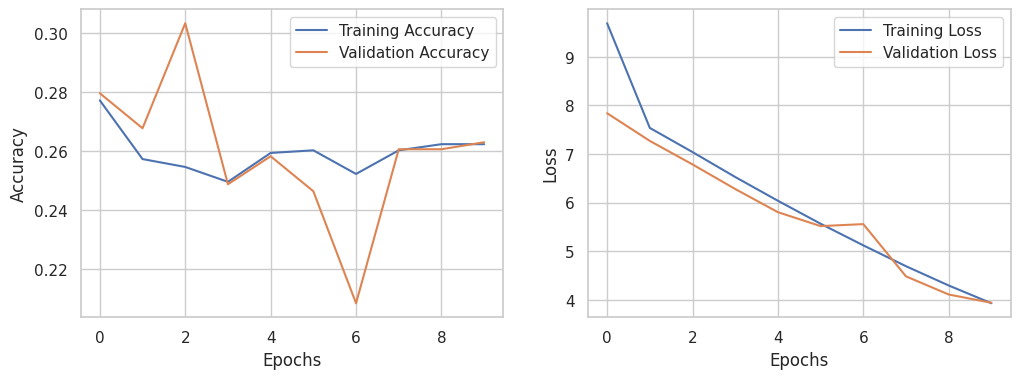

In [31]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Model Evaluation and Image Prediction for Ophthalmic Image Classification

In [37]:
model.save("Eye_Diseases_21STUCHH010369_355_342.keras")

In [38]:
model = load_model("/content/Eye_Diseases_21STUCHH010369_355_342.keras")

In [39]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

85/85 ━━━━━━━━━━━━━━━━━━━━ 45s 374ms/step - accuracy: 0.2576 - loss: 3.9061
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 694ms/step - accuracy: 0.2766 - loss: 3.8842
211/211 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.2446 - loss: 3.7602

Train Loss:  3.910064220428467
Train Accuracy:  0.26148828864097595
----------------------------------------
Validation Loss:  3.9400010108947754
Validation Accuracy:  0.2630331814289093
----------------------------------------
Test Loss:  3.757354259490967
Test Accuracy:  0.25829383730888367


In [41]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

211/211 ━━━━━━━━━━━━━━━━━━━━ 16s 30ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.25      0.02      0.04       104
diabetic_retinopathy       0.26      0.97      0.41       110
            glaucoma       0.00      0.00      0.00       101
              normal       0.00      0.00      0.00       107

            accuracy                           0.26       422
           macro avg       0.13      0.25      0.11       422
        weighted avg       0.13      0.26      0.12       422



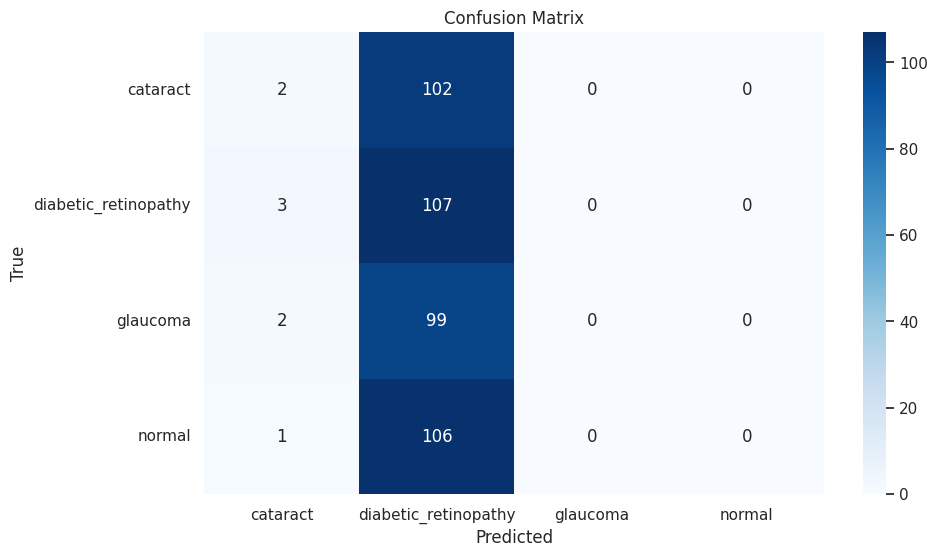

In [42]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


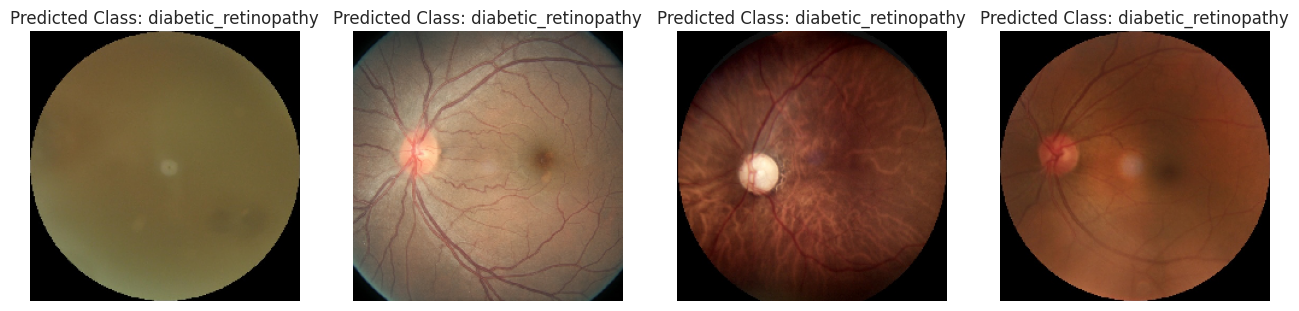

In [43]:
def predict_and_display_images(image_paths, model):
    class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '/content/dataset/cataract/0_left.jpg',
    '/content/dataset/diabetic_retinopathy/10009_right.jpeg',
    '/content/dataset/glaucoma/1212_left.jpg',
    '/content/dataset/normal/2329_left.jpg'
]


predict_and_display_images(image_paths, model)

###Activation Map Visualization and Attention Map Generation

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


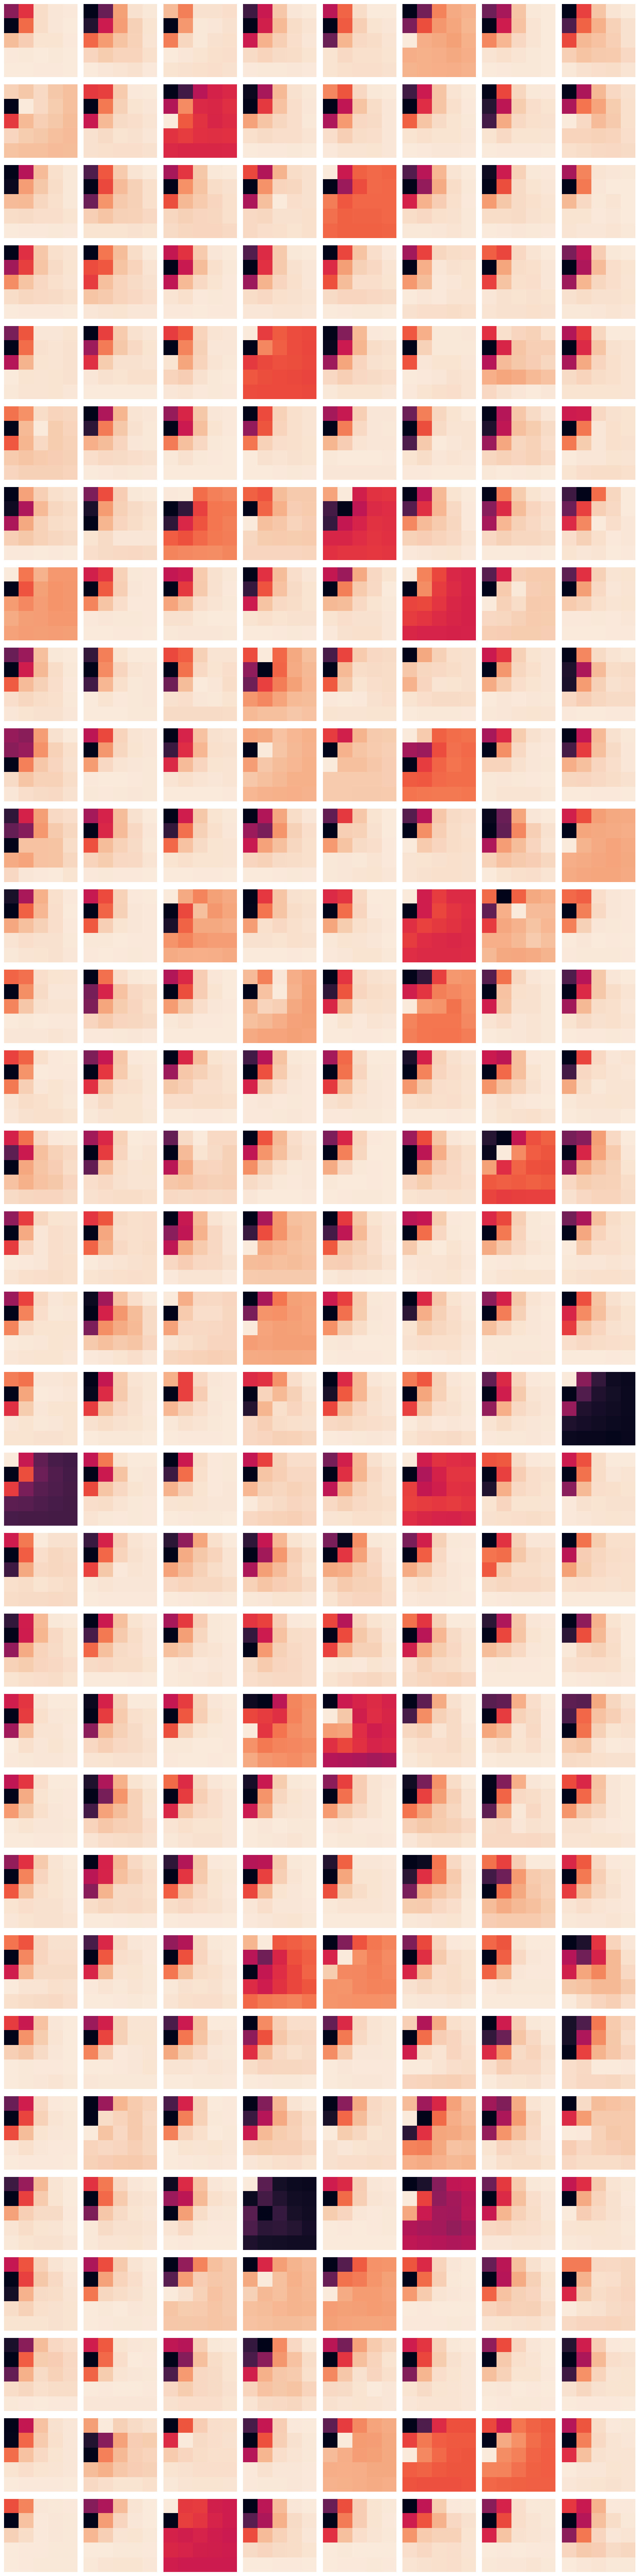

In [45]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_202'
img_path = '/content/dataset/glaucoma/1020_left.jpg'

visualize_activation_maps(model, img_path, layer_name)

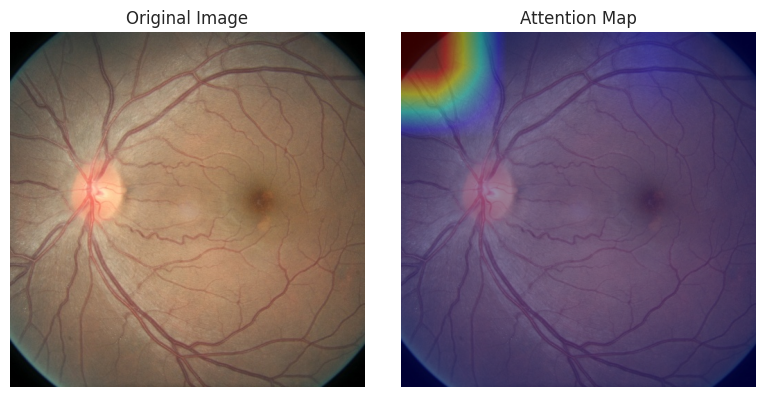

In [46]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/content/dataset/diabetic_retinopathy/10009_right.jpeg'
img = load_img(image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv_7b_ac'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

##Convolutional Neural Network(CNN)

###Convolutional Neural Network Architecture

In [47]:
model = Sequential()

model.add(Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))

model.add(Dense(4, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_203 (Conv2D)                  │ (None, 218, 218, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_204              │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_204 (Conv2D)                  │ (None, 107, 107, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 53, 53, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_205              │ (None, 53, 53, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_205 (Conv2D)                  │ (None, 51, 51, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 25, 25, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_206              │ (None, 25, 25, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_206 (Conv2D)                  │ (None, 23, 23, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 11, 11, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_207              │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_207 (Conv2D)                  │ (None, 9, 9, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_208              │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_208 (Conv2D)                  │ (None, 2, 2, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_209              │ (None, 2, 2, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │              

 Total params: 2,008,580 (7.66 MB)

 Trainable params: 2,006,468 (7.65 MB)

 Non-trainable params: 2,112 (8.25 KB)

###Training the Model

In [49]:
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath = 'Eye_Diseases_21STUCHH010369_355_342.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

In [50]:
history_cnn = model.fit(x= train_set,
                        epochs= 50,
                        verbose= 1,
                        validation_data= valid_set,
                        callbacks = [checkpoint_callback]
)

Epoch 1/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5110 - loss: 1.1478
Epoch 1: val_accuracy improved from -inf to 0.60190, saving model to Eye_Diseases_21STUCHH010369_355_342.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 51s 438ms/step - accuracy: 0.5121 - loss: 1.1454 - val_accuracy: 0.6019 - val_loss: 0.9237
Epoch 2/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.7519 - loss: 0.5885
Epoch 2: val_accuracy improved from 0.60190 to 0.79384, saving model to Eye_Diseases_21STUCHH010369_355_342.keras
85/85 ━━━━━━━━━━━━━━━━━━━━ 60s 283ms/step - accuracy: 0.7522 - loss: 0.5881 - val_accuracy: 0.7938 - val_loss: 0.5263
Epoch 3/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.7918 - loss: 0.5107
Epoch 3: val_accuracy did not improve from 0.79384
85/85 ━━━━━━━━━━━━━━━━━━━━ 26s 283ms/step - accuracy: 0.7919 - loss: 0.5104 - val_accuracy: 0.7796 - val_loss: 0.5532
Epoch 4/50
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8238 - loss: 0.4343
Epoch 4: val_accuracy did 

###Training and Validation Performance Visualization

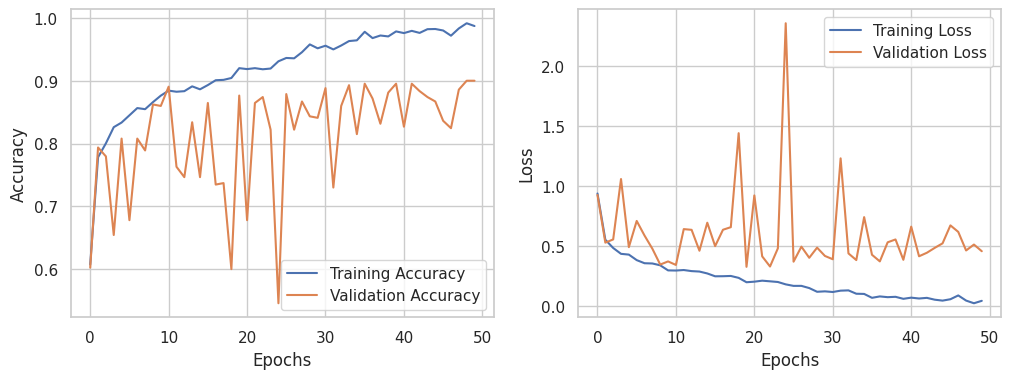

In [51]:
train_accuracy = history_cnn.history['accuracy']
val_accuracy = history_cnn.history['val_accuracy']
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

###Model Evaluation and Image Prediction for Ophthalmic Image Classification

In [61]:
model = load_model("/content/Eye_Diseases_21STUCHH010369_355_342.keras")

In [53]:
train_results = model.evaluate(train_set, verbose= 1)
valid_results = model.evaluate(valid_set, verbose= 1)
test_results = model.evaluate(test_set, verbose= 1)

print("\nTrain Loss: ", train_results[0])
print("Train Accuracy: ", train_results[1])
print('-' * 40)

print("Validation Loss: ", valid_results[0])
print("Validation Accuracy: ", valid_results[1])
print('-' * 40)

print("Test Loss: ", test_results[0])
print("Test Accuracy: ", test_results[1])

85/85 ━━━━━━━━━━━━━━━━━━━━ 31s 330ms/step - accuracy: 0.9978 - loss: 0.0107
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.9051 - loss: 0.4690
211/211 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.8652 - loss: 0.6697

Train Loss:  0.012961611151695251
Train Accuracy:  0.9961458444595337
----------------------------------------
Validation Loss:  0.5104738473892212
Validation Accuracy:  0.900473952293396
----------------------------------------
Test Loss:  0.5481434464454651
Test Accuracy:  0.8862559199333191


In [55]:
class_names = list(test_set.class_indices.keys())

predictions = model.predict(test_set, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)

true_labels = test_set.classes

class_report = classification_report(true_labels, predicted_labels, target_names = class_names)
print("Classification Report:\n", class_report)

211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report:
                       precision    recall  f1-score   support

            cataract       0.93      0.94      0.94       104
diabetic_retinopathy       0.99      0.99      0.99       110
            glaucoma       0.78      0.82      0.80       101
              normal       0.83      0.79      0.81       107

            accuracy                           0.89       422
           macro avg       0.88      0.89      0.88       422
        weighted avg       0.89      0.89      0.89       422



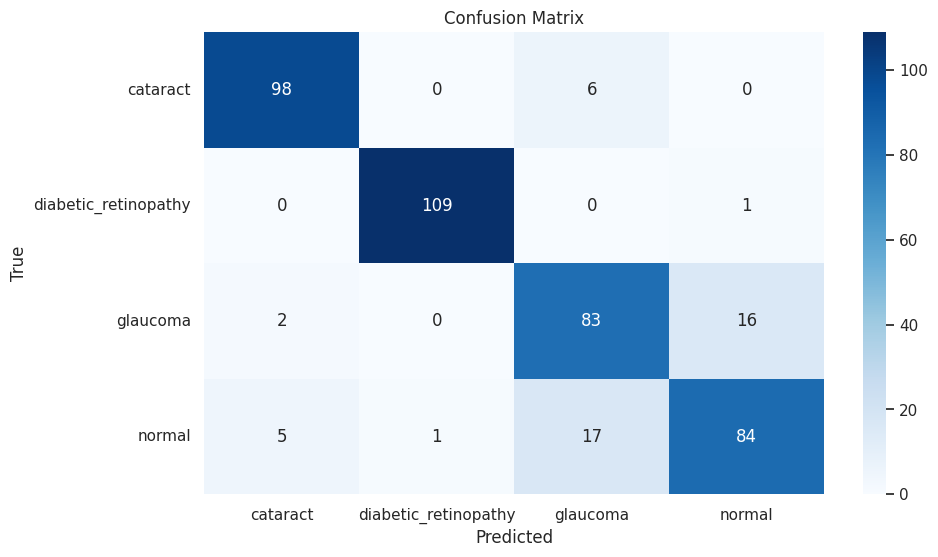

In [56]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


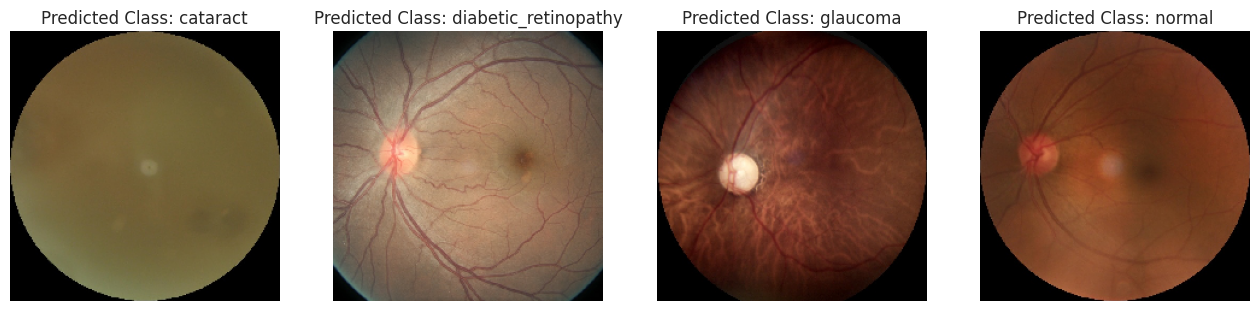

In [57]:
def predict_and_display_images(image_paths, model):
    class_labels = ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    for i, image_path in enumerate(image_paths):
        img = image.load_img(image_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        predictions = model.predict(img)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        predicted_class = class_labels[predicted_class_index]

        ax = axes[i]
        ax.imshow(img[0] / 255.0)
        ax.set_title(f"Predicted Class: {predicted_class}")
        ax.axis('off')

    plt.show()

image_paths = [
    '/content/dataset/cataract/0_left.jpg',
    '/content/dataset/diabetic_retinopathy/10009_right.jpeg',
    '/content/dataset/glaucoma/1212_left.jpg',
    '/content/dataset/normal/2329_left.jpg'
]


predict_and_display_images(image_paths, model)

###Activation Map Visualization and Attention Map Generation

In [74]:
model = load_model("/content/Eye_Diseases_21STUCHH010369_355_342.keras")
# Define the output shape
output_shape = (218, 218, 32)

# Create a dummy tensor with the output shape
output_tensor = tf.TensorSpec(shape=(None, *output_shape), dtype=tf.float32)
print("Output Tensor:", output_tensor)

import tensorflow as tf

# Define the input shape
input_shape = (224, 224, 3)

# Convert to a Keras tensor
input_tensor = tf.keras.Input(shape=input_shape)
print("Input Tensor:", input_tensor)


Output Tensor: TensorSpec(shape=(None, 218, 218, 32), dtype=tf.float32, name=None)
Input Tensor: <KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_4070>
